In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from autoencoder import Autoencoder, trainAutoencoder
from data_loader import RawDataLoader
from utils import RAW_BOTH_DATA_FOLDER, BOTH_SCREENING_DATA_FOLDER, TCGA_DATA_FOLDER, TCGA_SCREENING_DATA, DRUG_DATA_FOLDER

In [2]:
# Charger les données cellulaires via RawDataLoader.load_data()

data_modalities = ['cell_exp', 'drug_finger']
data_dict, screening = RawDataLoader.load_data(
    data_modalities=data_modalities,
    raw_file_directory=RAW_BOTH_DATA_FOLDER,
    screen_file_directory=BOTH_SCREENING_DATA_FOLDER,  
    sep="\t",
    drug_directory=DRUG_DATA_FOLDER
)

Reading Raw Data Files...:   0%|                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader.py:142: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:   0%|                                                                 | 0/8 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader.py:142: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...: 100%|█████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.12it/s]


In [3]:
print(screening.shape)
print(screening.head())

(373, 690)
                I-BRD9  Lenalidomide  itraconazole  Wnt-C59  3-Cl-AHPC  \
CELL_LINE_NAME                                                           
EFM-192A           0.0           0.0           0.0      0.0        0.0   
Farage             0.0           0.0           0.0      0.0        0.0   
TUHR14TKB          0.0           0.0           0.0      0.0        0.0   
LS411N             0.0           0.0           0.0      0.0        0.0   
JIMT-1             0.0           0.0           0.0      0.0        0.0   

                procarbazine  AGK2  BRD-K55473186  Cyclophosphamide  \
CELL_LINE_NAME                                                        
EFM-192A                 0.0   0.0            0.0               0.0   
Farage                   0.0   0.0            0.0               1.0   
TUHR14TKB                1.0   0.0            0.0               0.0   
LS411N                   0.0   0.0            0.0               0.0   
JIMT-1                   0.0   0.0          

In [4]:
# Préparer X_cell
def prepare_cell_input_data(data_dict, screening):

    # Trouver les indices où screening == 1 (résistance) et -1 (sensibilité)
    resistance = np.argwhere(screening.to_numpy() == 1).tolist()
    resistance.sort(key=lambda x: (x[0], x[1]))  # trier par ligne puis colonne
    resistance = np.array(resistance)
    
    sensitive = np.argwhere(screening.to_numpy() == -1).tolist()
    sensitive.sort(key=lambda x: (x[0], x[1]))
    sensitive = np.array(sensitive)
    
    print(f"sensitive data len: {len(sensitive)}")
    print(f"resistance data len: {len(resistance)}")
    
    # Construire le DataFrame pour les données cellulaires en ne gardant que les modalités qui commencent par 'cell'
    cell_data_types = list(filter(lambda x: x.startswith('cell'), data_dict.keys()))
    cell_data_types.sort()
    cell_data = pd.concat(
        [pd.DataFrame(data_dict[data_type].add_suffix(f'_{data_type}'), dtype=np.float32)
         for data_type in cell_data_types],
        axis=1
    )
    print(f"Taille de cell_data: {cell_data.shape}")
    
    # Extraire les échantillons de résistance et sensibilité
    Xp_cell = cell_data.iloc[resistance[:, 0], :].reset_index(drop=True)
    Xp_cell.index = [f'{screening.index[x[0]]}' for x in resistance]
    
    Xn_cell = cell_data.iloc[sensitive[:, 0], :].reset_index(drop=True)
    Xn_cell.index = [f'{screening.index[x[0]]}' for x in sensitive]
    
    # Concaténer les échantillons pour avoir l'ensemble complet
    X_cell = pd.concat([Xp_cell, Xn_cell])
    
    # Créer le vecteur de labels : 0 pour résistance, 1 pour sensibilité
    Y = np.append(np.zeros(resistance.shape[0]), np.ones(sensitive.shape[0]))
    
    return X_cell, Y

In [5]:
X_cell, Y = prepare_cell_input_data(data_dict, screening)
print(f"Taille de X_cell: {X_cell.shape}")

sensitive data len: 1895
resistance data len: 4641
Taille de cell_data: (373, 19221)
Taille de X_cell: (6536, 19221)


In [6]:
# Préparer X_cell pour t-SNE
# Transformer X_cell en tenseur PyTorch et normaliser
cell_tensor = torch.tensor(X_cell.values, dtype=torch.float32)
cell_tensor = torch.nn.functional.normalize(cell_tensor, dim=0)

In [7]:
# Entraîner l'autoencodeur sur l'ensemble des données cellulaires
latent_dim = 50  
input_dim = X_cell.shape[1]
autoencoder_cell = Autoencoder(input_dim, latent_dim)

# Créer un TensorDataset et un DataLoader
dataset_cell = TensorDataset(cell_tensor)
batch_size = 64
data_loader_cell = DataLoader(dataset_cell, batch_size=batch_size, shuffle=True)

# Définir le nombre d'epoch d'entraînement
num_epochs = 25

# Entraîner l'autoencodeur sur l'ensemble complet des données
trainAutoencoder(autoencoder_cell, data_loader_cell, data_loader_cell, num_epochs, name='_cell')

# Extraire la représentation latente

# Passer l'autoencodeur en mode évaluation
autoencoder_cell.eval()

# Calculer la représentation latente en passant l'ensemble complet des données par l'encodeur
with torch.no_grad():
    latent_representation_cell = autoencoder_cell.encoder(cell_tensor)

# Convertir la représentation latente en tableau NumPy pour l'utiliser avec t-SNE
latent_representation_cell = latent_representation_cell.numpy()

Epoch [1/25], Train Loss: 0.0847, Val Loss: 0.0064
Epoch [2/25], Train Loss: 0.0064, Val Loss: 0.0063
Epoch [3/25], Train Loss: 0.0060, Val Loss: 0.0059
Epoch [4/25], Train Loss: 0.0057, Val Loss: 0.0057
Epoch [5/25], Train Loss: 0.0056, Val Loss: 0.0056
Epoch [6/25], Train Loss: 0.0056, Val Loss: 0.0056
Epoch [7/25], Train Loss: 0.0054, Val Loss: 0.0054
Epoch [8/25], Train Loss: 0.0052, Val Loss: 0.0052
Epoch [9/25], Train Loss: 0.0050, Val Loss: 0.0050
Epoch [10/25], Train Loss: 0.0049, Val Loss: 0.0048
Epoch [11/25], Train Loss: 0.0048, Val Loss: 0.0048
Epoch [12/25], Train Loss: 0.0046, Val Loss: 0.0046
Epoch [13/25], Train Loss: 0.0045, Val Loss: 0.0045
Epoch [14/25], Train Loss: 0.0044, Val Loss: 0.0044
Epoch [15/25], Train Loss: 0.0043, Val Loss: 0.0043
Epoch [16/25], Train Loss: 0.0042, Val Loss: 0.0042
Epoch [17/25], Train Loss: 0.0041, Val Loss: 0.0041
Epoch [18/25], Train Loss: 0.0040, Val Loss: 0.0040
Epoch [19/25], Train Loss: 0.0040, Val Loss: 0.0040
Epoch [20/25], Train 

In [8]:
# Appliquer t-SNE sur les données d'entrée normalisées (avant encodage)
tsne_input_cell = TSNE(n_components=2, random_state=42)
X_tsne_input_cell = tsne_input_cell.fit_transform(X_cell)

# Appliquer t-SNE sur les représentations latentes (après encodage)
tsne_latent_cell = TSNE(n_components=2, random_state=42)
X_tsne_latent_cell = tsne_latent_cell.fit_transform(latent_representation_cell)

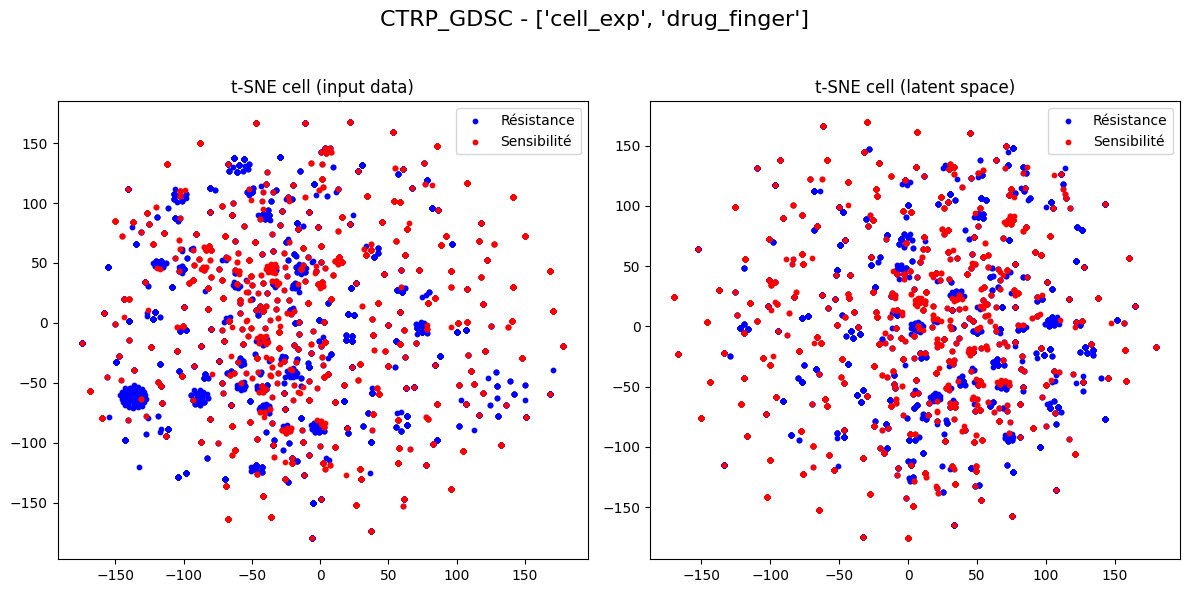

In [9]:
# Visualiser les résultats

plt.figure(figsize=(12, 6))

# Ajouter un titre
plt.suptitle("CTRP_GDSC - ['cell_exp', 'drug_finger']", fontsize=16)

# Sous-figure pour la projection t-SNE sur les données d'entrée
plt.subplot(1, 2, 1)
for class_value, color, label in zip([0, 1], ['blue', 'red'], ['Résistance', 'Sensibilité']):
    mask = (Y == class_value)
    plt.scatter(
        X_tsne_input_cell[mask, 0],
        X_tsne_input_cell[mask, 1],
        c=color,
        s=10,
        label=label
    )
plt.title("t-SNE cell (input data)")
plt.legend()

# Sous-figure pour la projection t-SNE sur l'espace latent
plt.subplot(1, 2, 2)
for class_value, color, label in zip([0, 1], ['blue', 'red'], ['Résistance', 'Sensibilité']):
    mask = (Y == class_value)
    plt.scatter(
        X_tsne_latent_cell[mask, 0],
        X_tsne_latent_cell[mask, 1],
        c=color,
        s=10,
        label=label
    )
plt.title("t-SNE cell (latent space)")
plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()